<center><h1>Yoo_Paul_Final_Project</h1></center>

Name: Paul Yoo 
<br>
Github Username: PKY-USCADS
<br>
USC ID: 9664-7785-73 

## 1. Text Classification

### (a) Importing Packages and Data 

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
pos_dir = '../data/pos'
neg_dir = '../data/neg'

### (b) Data Exploration and Pre-processing

#### (i-ii) Binary encoding for sentiments and Data cleaning
Removed punctuation and numbers from reviews

In [3]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.replace('\n', '')
    text = re.sub(r'\s+', ' ', text)
    return text.lower()

def load_reviews(directory):
    reviews = []
    for filename in sorted(os.listdir(directory)):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            review = file.read()
            clean_review = clean_text(review)
            reviews.append(clean_review)
    return reviews

In [4]:
pos_reviews = load_reviews(pos_dir)
neg_reviews = load_reviews(neg_dir)
pos_reviews[0:5]
neg_reviews[0:5]

['plot two teen couples go to a church party drink and then drive they get into an accident one of the guys dies but his girlfriend continues to see him in her life and has nightmares whats the deal watch the movie and sorta find out critique a mindfuck movie for the teen generation that touches on a very cool idea but presents it in a very bad package which is what makes this review an even harder one to write since i generally applaud films which attempt to break the mold mess with your head and such lost highway memento but there are good and bad ways of making all types of films and these folks just didnt snag this one correctly they seem to have taken this pretty neat concept but executed it terribly so what are the problems with the movie well its main problem is that its simply too jumbled it starts off normal but then downshifts into this fantasy world in which you as an audience member have no idea whats going on there are dreams there are characters coming back from the dead 

In [5]:
reviews = pos_reviews + neg_reviews
labels = [1] * len(pos_reviews) + [0] * len(neg_reviews)

#### (iii) Split train and test sets.

In [6]:
pos_train = pos_reviews[:700]
neg_train = neg_reviews[:700]
pos_test = pos_reviews[700:]
neg_test = neg_reviews[700:]

In [7]:
reviews_train = pos_train + neg_train
labels_train = [1] * 700 + [0] * 700
reviews_test = pos_test + neg_test
labels_test = [1] * 300 + [0] * 300

In [8]:
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

#### iv. Unique words

In [9]:
words = ''.join(reviews)
unique_words = len(set(words.split()))
unique_words

47037

#### v. Review Length

In [10]:
review_length = [len(review.split()) for review in reviews]
avg_review_length = np.mean(review_length)
std_review_length = np.std(review_length)
print(avg_review_length)
print(std_review_length)

644.3575
284.98012333099655


#### vi. Review Length Histogram

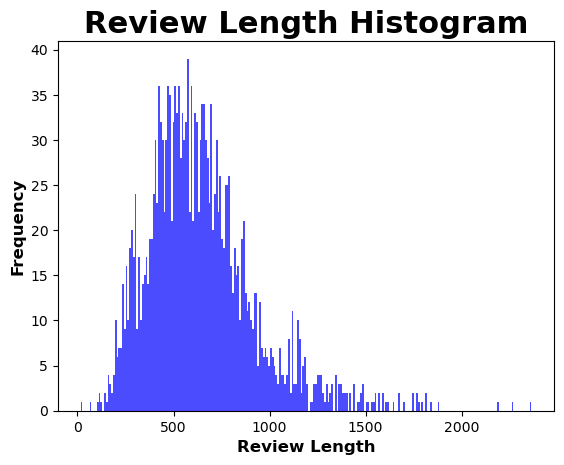

In [11]:
plt.hist(review_length, bins=250, color='blue', alpha=0.7)
plt.title('Review Length Histogram', fontsize=22, fontweight='bold')
plt.xlabel('Review Length', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.show()

#### vii. Tokenization

<font color='Cyan'>

Reference [1] for Tokenizer <br>
from tensorflow.keras.preprocessing.text import Tokenizer <br>
 <br>
Reference [2] for pad_sequences <br>
from tensorflow.keras.preprocessing.sequence import pad_sequences <br>

</font>

In [12]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews_train + reviews_test)

train_sequences = tokenizer.texts_to_sequences(reviews_train)
test_sequences = tokenizer.texts_to_sequences(reviews_test)

#### viii. Select Reviews that have length below 70%: L

In [13]:
L_70 = np.percentile(review_length, 70)
L = int(L_70)
print(L_70)

737.0


#### ix.Truncate Reviews longer than L words and zero-pad reviews shorter than L


In [14]:
seq_pad_train = pad_sequences(train_sequences, maxlen=L, padding='post', truncating='post')
seq_pad_test = pad_sequences(test_sequences, maxlen=L, padding='post', truncating='post')

In [15]:
print(seq_pad_train.shape)
print(seq_pad_test.shape)

(1400, 737)
(600, 737)


### (c) Word Embeddings

#### i. Embedding

<font color='Cyan'>

Reference [3] for Sequential <br>
from tensorflow.keras.models import Sequential <br>
 <br>
Reference [4] for Input <br>
from tensorflow.keras.layers import Input <br>
 <br>
Reference [5] for Embedding <br>
from tensorflow.keras.layers import Embedding <br>
 <br>
Reference [6] for Flatten <br>
from tensorflow.keras.layers import Flatten <br>
 <br>
Reference [7] for Keras Text Classifaction <br>
https://realpython.com/python-keras-text-classification/ <br>
 <br>
Reference [8] for Keras Embedding Layer <br>
https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer <br>
</font>

In [16]:
vocab_size = 5000
embedding_dim = 32

In [17]:
model_embedding = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='embedding'),
    Flatten(),
])

In [18]:
print(model_embedding.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23584)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,000 (625.00 KB)

 Trainable params: 160,000 (625.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
train_embeddings = model_embedding.predict(seq_pad_train)
test_embeddings = model_embedding.predict(seq_pad_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step


In [20]:
print(train_embeddings.shape)
print(test_embeddings.shape)

(1400, 23584)
(600, 23584)


In [21]:
weights_embedding = model_embedding.get_layer('embedding').get_weights()

In [22]:
weights_embedding

[array([[-0.02380102, -0.01036191, -0.01337112, ..., -0.00537016,
         -0.00760038, -0.04689744],
        [-0.01443589,  0.00757673, -0.0479769 , ...,  0.01814722,
         -0.04701132,  0.00215247],
        [ 0.02630151, -0.03847845,  0.00986178, ...,  0.02729886,
          0.00781105,  0.01136418],
        ...,
        [-0.02988317,  0.04945249, -0.0326362 , ...,  0.0376276 ,
          0.04628843, -0.00503528],
        [-0.03081195,  0.02328899, -0.01434474, ...,  0.02242369,
          0.00229847,  0.03645339],
        [ 0.03301283,  0.0037114 ,  0.00293043, ..., -0.03209348,
         -0.04480059, -0.007946  ]], dtype=float32)]

### (d) Multi-Layer Perceptron

#### i. Train MLP
The guideline asks to use epochs = 2, batch_size = 10, but I tried extra combination to find optimal epochs and batch size with better validation accuracy. 

<font color='Cyan'>

Reference [9] for Dense <br>
from tensorflow.keras.layers import Dense <br>
 <br>
Reference [10] for Dropout <br>
from tensorflow.keras.layers import Dropout <br>
 <br>
Reference [11] for Machine Learning Mastery MLP Neural Network Model <br>
https://machinelearningmastery.com/build-multi-layer-perceptron-neural-network-models-keras/ <br>
 <br>
Reference [12] for DataCamp Concept of MLP in Machine Learning <br>
https://www.datacamp.com/tutorial/multilayer-perceptrons-in-machine-learning <br>
 <br>
Reference [13] for Towards Data Science for article reference <br>
https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141 <br>
 <br>
Reference [14] for ScienceDirect <br>
https://www.sciencedirect.com/topics/computer-science/multilayer-perceptron <br>

</font>

In [23]:
mlp_model = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='mlp_embedding'),
    Flatten(),
    Dense(50, activation='relu', name='mlp_relu1'),
    Dropout(0.2),
    Dense(50, activation='relu', name='mlp_relu2'),
    Dropout(0.5),
    Dense(50, activation='relu', name='mlp_relu3'),
    Dropout(0.5),
    Dense(1, activation='sigmoid', name='mlp_sigmoid')
])

In [24]:
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
mlp_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mlp_embedding (Embedding)       │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 23584)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_relu1 (Dense)               │ (None, 50)             │     1,179,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_relu2 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_relu3 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mlp_sigmoid (Dense)             │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,344,401 (5.13 MB)

 Trainable params: 1,344,401 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
mlp_epochs_list = [2, 5, 10]
mlp_batch_sizes = [10, 20, 30]

mlp_original_accuracy = 0
mlp_original_loss = 0
mlp_original_val_loss =0
mlp_original_val_accuracy = 0

mlp_best_accuracy = 0
mlp_best_loss = 0
mlp_best_val_loss =0
mlp_best_val_accuracy = 0

mlp_best_epoch = 0
mlp_best_batch_size = 0
mlp_best_history = None

In [27]:
for epochs in mlp_epochs_list:
    for batch_size in mlp_batch_sizes:
        print("")
        print(f"Training with epochs = {epochs} and batch size = {batch_size}")
        print("")
        mlp_history = mlp_model.fit(seq_pad_train, labels_train, epochs=epochs, batch_size=batch_size, validation_data=(seq_pad_test, labels_test), verbose=1)
        
        accuracy = max(mlp_history.history['accuracy'])
        loss = max(mlp_history.history['loss'])        
        val_accuracy = max(mlp_history.history['val_accuracy'])
        val_loss = max(mlp_history.history['val_loss'])
        
        if epochs == 2 and batch_size == 10:
            mlp_original_accuracy = accuracy
            mlp_original_loss = loss
            mlp_original_val_accuracy = val_accuracy
            mlp_original_val_loss = val_loss
        
        if val_accuracy > mlp_best_val_accuracy:
            mlp_best_accuracy = accuracy
            mlp_best_loss = loss
            mlp_best_val_loss = val_loss
            mlp_best_val_accuracy = val_accuracy
            mlp_best_epoch = epochs
            mlp_best_batch_size = batch_size
            mlp_best_history = mlp_history


Training with epochs = 2 and batch size = 10

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4981 - loss: 0.6963 - val_accuracy: 0.5133 - val_loss: 0.6906
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5893 - loss: 0.6713 - val_accuracy: 0.6133 - val_loss: 0.6625

Training with epochs = 2 and batch size = 20

Epoch 1/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8461 - loss: 0.4149 - val_accuracy: 0.6017 - val_loss: 0.7404
Epoch 2/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9695 - loss: 0.1280 - val_accuracy: 0.6050 - val_loss: 1.0131

Training with epochs = 2 and batch size = 30

Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0268 - val_accuracy: 0.6050 - val_loss: 1.2694
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 - loss: 0.0212 - val_accuracy: 0.6200 - val_loss: 1.3266

Training with epochs = 5 and batch size = 10

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accur

#### ii. Train and Test Accuracies



In [28]:
print(f"Best validation accuracy: {mlp_best_val_accuracy:.4f} when epochs = {mlp_best_epoch} and batch size = {mlp_best_batch_size}")
print(f"with training accuracy: {mlp_best_accuracy:.4f}, training loss: {mlp_best_loss:.8f}, and validation loss: {mlp_best_val_loss:.4f}")
print("")
print(f"When epochs = 2 and batch size = 10, validation accuracy: {mlp_original_val_accuracy:.4f}")
print(f"with training accuracy: {mlp_original_accuracy:.4f}, training loss: {mlp_original_loss:.8f}, and validation loss: {mlp_original_val_loss:.4f}")

Best validation accuracy: 0.6200 when epochs = 2 and batch size = 30
with training accuracy: 0.9979, training loss: 0.02190609, and validation loss: 1.3266

When epochs = 2 and batch size = 10, validation accuracy: 0.6133
with training accuracy: 0.6071, training loss: 0.69486505, and validation loss: 0.6906


In [29]:
if mlp_best_val_accuracy > mlp_original_val_accuracy:
    print(f"When comparing, the project guideline tells to use epochs = 2 and batch size = 10, but from the model training, it shows that using epochs = {mlp_best_epoch} and batch size = {mlp_best_batch_size} gives better fitted model for the classification. However, since this model has higher validation loss, which indicates potential overfit issue leading to further tuning for reduction of overfitting.")
else:
    print("It shows that using epoch = 2 and batch size = 10 as project guideline directed returns the highest validation accuracy, which means the best fitted model for classification.")

When comparing, the project guideline tells to use epochs = 2 and batch size = 10, but from the model training, it shows that using epochs = 2 and batch size = 30 gives better fitted model for the classification. However, since this model has higher validation loss, which indicates potential overfit issue leading to further tuning for reduction of overfitting.


### (e) One-Dimensional Convolutional Neural Network

#### i. train convolutional neural network model
The guideline asks to use epochs = 2, batch_size = 10 same as MLP model, but I tried extra combination to find optimal epochs and batch size with better validation accuracy. 

<font color='Cyan'>

Reference [15] for Conv1D <br>
from tensorflow.keras.layers import Conv1D <br>
 <br>
Reference [16] for MaxPooling1D <br>
from tensorflow.keras.layers import MaxPooling1D <br>
 <br>
Reference [17] for GeeksforGeeks Concept of Convolutional Neural Network <br>
https://www.geeksforgeeks.org/what-is-a-1d-convolutional-layer-in-deep-learning/ <br>
 <br>
Reference [18] for ScienceDirect for article reference <br>
https://www.sciencedirect.com/science/article/pii/S0888327020307846 <br>

</font>

In [30]:
cnn_model = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='cnn_embedding'),
    Conv1D(32, 3, activation='relu', name='cnn_Cov1D'),
    MaxPooling1D(pool_size=2, strides=2),
    Flatten(),
    Dense(50, activation='relu', name='cnn_relu1'),
    Dropout(0.2),
    Dense(50, activation='relu', name='cnn_relu2'),
    Dropout(0.5),
    Dense(50, activation='relu', name='cnn_relu3'),
    Dropout(0.5),
    Dense(1, activation='sigmoid', name='cnn_sigmoid')
])

In [31]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cnn_embedding (Embedding)       │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_Cov1D (Conv1D)              │ (None, 735, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 367, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 11744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_relu1 (Dense)               │ (None, 50)             │       587,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_relu2 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_relu3 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_sigmoid (Dense)             │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 755,505 (2.88 MB)

 Trainable params: 755,505 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
cnn_epochs_list = [2, 5, 10]
cnn_batch_sizes = [10, 20, 30]

cnn_original_accuracy = 0
cnn_original_loss = 0
cnn_original_val_loss =0
cnn_original_val_accuracy = 0

cnn_best_accuracy = 0
cnn_best_loss = 0
cnn_best_val_loss =0
cnn_best_val_accuracy = 0

cnn_best_epoch = 0
cnn_best_batch_size = 0
cnn_best_history = None

In [34]:
for epochs in cnn_epochs_list:
    for batch_size in cnn_batch_sizes:
        print("")
        print(f"Training with epochs = {epochs} and batch size = {batch_size}")
        print("")
        cnn_history = cnn_model.fit(seq_pad_train, labels_train, epochs=epochs, batch_size=batch_size, validation_data=(seq_pad_test, labels_test), verbose=1)
        
        accuracy = max(cnn_history.history['accuracy'])
        loss = max(cnn_history.history['loss'])        
        val_accuracy = max(cnn_history.history['val_accuracy'])
        val_loss = max(cnn_history.history['val_loss'])
        
        if epochs == 2 and batch_size == 10:
            cnn_original_accuracy = accuracy
            cnn_original_loss = loss
            cnn_original_val_accuracy = val_accuracy
            cnn_original_val_loss = val_loss
        
        if val_accuracy > cnn_best_val_accuracy:
            cnn_best_accuracy = accuracy
            cnn_best_loss = loss
            cnn_best_val_loss = val_loss
            cnn_best_val_accuracy = val_accuracy
            cnn_best_epoch = epochs
            cnn_best_batch_size = batch_size
            cnn_best_history = cnn_history


Training with epochs = 2 and batch size = 10

Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4929 - loss: 0.7081 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5107 - loss: 0.6918 - val_accuracy: 0.5517 - val_loss: 0.6903

Training with epochs = 2 and batch size = 20

Epoch 1/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5891 - loss: 0.6774 - val_accuracy: 0.5817 - val_loss: 0.6802
Epoch 2/2
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7096 - loss: 0.6263 - val_accuracy: 0.6917 - val_loss: 0.6315

Training with epochs = 2 and batch size = 30

Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8835 - loss: 0.4474 - val_accuracy: 0.6100 - val_loss: 0.7723
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9404 - loss: 0.3044 - val_accuracy: 0.7267 - val_loss: 0.6943

Training with epochs = 5 and batch size = 10

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accu

#### ii. Train and Test Accuracies

In [35]:
print(f"Best validation accuracy: {cnn_best_val_accuracy:.4f} when epochs = {cnn_best_epoch} and batch size = {cnn_best_batch_size}")
print(f"with training accuracy: {cnn_best_accuracy:.4f}, training loss: {cnn_best_loss:.8f}, and validation loss: {cnn_best_val_loss:.4f}")
print("")
print(f"When epochs = 2 and batch size = 10, validation accuracy: {cnn_original_val_accuracy:.4f}")
print(f"with training accuracy: {cnn_original_accuracy:.4f}, training loss: {cnn_original_loss:.8f}, and validation loss: {cnn_original_val_loss:.4f}")

Best validation accuracy: 0.7567 when epochs = 5 and batch size = 20
with training accuracy: 0.9936, training loss: 0.06047726, and validation loss: 1.9220

When epochs = 2 and batch size = 10, validation accuracy: 0.5517
with training accuracy: 0.5014, training loss: 0.69963944, and validation loss: 0.6925


In [36]:
if cnn_best_val_accuracy > cnn_original_val_accuracy:
    print(f"When comparing, the project guideline tells to use epochs = 2 and batch size = 10, but from the model training, it shows that using epochs = {cnn_best_epoch} and batch size = {cnn_best_batch_size} gives better fitted model for the classification.")
else:
    print("It shows that using epoch = 2 and batch size = 10 as project guideline directed returns the highest validation accuracy, which means the best fitted model for classification.")

When comparing, the project guideline tells to use epochs = 2 and batch size = 10, but from the model training, it shows that using epochs = 5 and batch size = 20 gives better fitted model for the classification.


### (f) Long Short-Term Memory Recurrent Neural Network

#### i. train LSTM recurrent neural network model
The guideline asks to use epochs = 10~50, batch_size = 10, but I tried extra combination using extra batch size to find optimal epochs and batch size with better validation accuracy.

<font color='Cyan'>

Reference [19] for LSTM <br>
from tensorflow.keras.layers import LSTM <br>
 <br>
Reference [20] for TensorFlow RNN Guide <br>
https://www.tensorflow.org/guide/keras/working_with_rnns <br>
 <br>
Reference [21] for Turing Concept of RNN and LSTM <br>
https://www.turing.com/kb/recurrent-neural-networks-and-lstm <br>
 <br>
Reference [22] for Aditi Mittal's Medium article <br>
https://aditi-mittal.medium.com/understanding-rnn-and-lstm-f7cdf6dfc14e 

</font>

In [37]:
rnn_model = Sequential([
    Input(shape=(L,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='rnn_embedding'),
    LSTM(256, activation='relu', return_sequences=True, name='rnn_LSTM1'),
    Dropout(0.2),
    LSTM(256, activation='relu', return_sequences=True, name='rnn_LSTM2'),
    Dropout(0.2),
    LSTM(256, activation='relu', name='rnn_LSTM3'),
    Dropout(0.2),
    Dense(256, activation='relu', name='rnn_relu1'),
    Dropout(0.2),
    Dense(1, activation='sigmoid', name='rnn_sigmoid')
])

#### Due to repeated nan value return for training loss using epoch 10~50, batch size = 10,
#### which keeps outputting 0.5 for validation accuracy and nan value for validation loss,
#### I would like to try higher batch size, which is 30 and 50, and learning rate = 0.001 (or smaller) to have training loss non-nan value.

In [41]:
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_embedding (Embedding)       │ (None, 737, 32)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_LSTM1 (LSTM)                │ (None, 737, 256)       │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 737, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_LSTM2 (LSTM)                │ (None, 737, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 737, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_LSTM3 (LSTM)                │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_relu1 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_sigmoid (Dense)             │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,572,609 (6.00 MB)

 Trainable params: 1,572,609 (6.00 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
rnn_epochs_list = [10]
rnn_batch_sizes = [30, 50]

rnn_original_accuracy = 0
rnn_original_loss = 0
rnn_original_val_loss =0
rnn_original_val_accuracy = 0

rnn_best_accuracy = 0
rnn_best_loss = 0
rnn_best_val_loss =0
rnn_best_val_accuracy = 0

rnn_best_epoch = 0
rnn_best_batch_size = 0
rnn_best_history = None

In [44]:
for epochs in rnn_epochs_list:
    for batch_size in rnn_batch_sizes:
        print("")
        print(f"Training with epochs = {epochs} and batch size = {batch_size}")
        print("")
        rnn_history = rnn_model.fit(seq_pad_train, labels_train, epochs=epochs, batch_size=batch_size, validation_data=(seq_pad_test, labels_test), verbose=1)
        
        accuracy = max(rnn_history.history['accuracy'])
        loss = max(rnn_history.history['loss'])        
        val_accuracy = max(rnn_history.history['val_accuracy'])
        val_loss = max(rnn_history.history['val_loss'])
        
        if epochs == 10 and batch_size == 10:
            rnn_original_accuracy = accuracy
            rnn_original_loss = loss
            rnn_original_val_accuracy = val_accuracy
            rnn_original_val_loss = val_loss
        
        if val_accuracy > rnn_best_val_accuracy:
            rnn_best_accuracy = accuracy
            rnn_best_loss = loss
            rnn_best_val_loss = val_loss
            rnn_best_val_accuracy = val_accuracy
            rnn_best_epoch = epochs
            rnn_best_batch_size = batch_size
            rnn_best_history = rnn_history


Training with epochs = 10 and batch size = 30

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.5064 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.4899 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.5001 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.5113 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.5013 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.4774 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.5019 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5122 - loss: nan - val_accuracy: 0.5000 

##### ii. Train and Test Accuracies

In [49]:
print(f"Validation accuracy: {rnn_best_val_accuracy:.4f} when epochs = {rnn_best_epoch} and batch size = {rnn_best_batch_size} with training accuracy: {rnn_best_accuracy:.4f}, training loss: {rnn_best_loss:.8f}, and validation loss: {rnn_best_val_loss:.4f}")
print("")
print("Training loss still remains to be nan, which results that validation accuracy to be remain as 0.5. There possibly be several reasons.")

Validation accuracy: 0.5000 when epochs = 10 and batch size = 30 with training accuracy: 0.5000, training loss: nan, and validation loss: nan

Training loss still remains to be nan, which results that validation accuracy to be remain as 0.5. There possibly be several reasons.


1.	Learning Rate Too High: If the learning rate is too high, the model’s weights might diverge, leading to NaN values. <br>
 ⇒ Need to reduce the learning rate. <br>
2.	Data Issues: There might be NaN or infinite values or too many zero values in input data. <br>
 ⇒ Need to ensure the data is clean and preprocessed correctly. <br>
3. Gradient Explosion: Large gradients can cause weights to update to NaN values. <br>
 ⇒ Need to use gradient clipping to cap the gradients during backpropagation. <br>
4. Batch Size: Very small or very large batch sizes can sometimes cause instability in training. <br>
 ⇒ Need different batch sizes. <br>

And I assume that the most significant affect for training loss having nan value is because of the zero values in input data generated when padding or truncating each text for pre-processing. <br>
Therefore, we might need different way to handle data to resolve the problem, such as using the lower percentile for review length (L) like 30% instead of 70% to have less zero values in input data.

### (EXTRA) Model Comparison by validation accuracy rate

In [54]:
if rnn_best_val_accuracy > cnn_best_val_accuracy > mlp_best_val_accuracy:
    print(f"When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, LSTM RNN model showed highest validation accuracy = {rnn_best_val_accuracy:.4f} followed by 1-D CNN model validation accuracy = {cnn_best_val_accuracy:.4f}. And MLP NN model had lowest validation accuracy = {mlp_best_val_accuracy:.4f}. Therefore, select LSTM RNN model.")
elif rnn_best_val_accuracy > mlp_best_val_accuracy > cnn_best_val_accuracy:
    print(f"When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, LSTM RNN model showed highest validation accuracy = {rnn_best_val_accuracy:.4f} followed by MLP NN model validation accuracy = {mlp_best_val_accuracy:.4f}. And 1-D CNN model had lowest validation accuracy = {cnn_best_val_accuracy:.4f}. Therefore, select LSTM RNN model.")
elif cnn_best_val_accuracy > rnn_best_val_accuracy > mlp_best_val_accuracy:
    print(f"When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, 1-D CNN model showed highest validation accuracy = {cnn_best_val_accuracy:.4f} followed by LSTM RNN model validation accuracy = {rnn_best_val_accuracy:.4f}. And MLP NN model had lowest validation accuracy = {mlp_best_val_accuracy:.4f}. Therefore, select 1-D CNN model.")
elif cnn_best_val_accuracy > mlp_best_val_accuracy > rnn_best_val_accuracy:
    print(f"When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, 1-D CNN model showed highest validation accuracy = {cnn_best_val_accuracy:.4f} followed by MLP NN model validation accuracy = {mlp_best_val_accuracy:.4f}. And LSTM RNN model had lowest validation accuracy = {rnn_best_val_accuracy:.4f}. Therefore, select 1-D CNN model.")
elif mlp_best_val_accuracy > rnn_best_val_accuracy > cnn_best_val_accuracy:
    print(f"When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, MLP NN model showed highest validation accuracy = {mlp_best_val_accuracy:.4f} followed by LSTM RNN model validation accuracy = {rnn_best_val_accuracy:.4f}. And 1-D CNN model had lowest validation accuracy = {cnn_best_val_accuracy:.4f}. Therefore, select MLP NN model.")
elif mlp_best_val_accuracy > cnn_best_val_accuracy > rnn_best_val_accuracy:
    print(f"When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, MLP NN model showed highest validation accuracy = {mlp_best_val_accuracy:.4f} followed by 1-D CNN model validation accuracy = {cnn_best_val_accuracy:.4f}. And LSTM RNN model had lowest validation accuracy = {rnn_best_val_accuracy:.4f}. Therefore, select MLP NN model.")
else:
    print(f"Two or All models have same validation accuracy that MLP NN model validation accuracy = {mlp_best_val_accuracy:.4f}, 1-D CNN model validation accuracy = {cnn_best_val_accuracy:.4f}, and LSTM RNN model validation accuracy = {rnn_best_val_accuracy:.4f}. Therefore, select any model with highest validation accuracy.")    

When comparing three models, MLP NN, 1-D CNN, and LSTM RNN, 1-D CNN model showed highest validation accuracy = 0.7567 followed by MLP NN model validation accuracy = 0.6200. And LSTM RNN model had lowest validation accuracy = 0.5000. Therefore, select 1-D CNN model.
